In [ ]:
pip install pandas matplotlib seaborn scikit-learn


In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

with open("db_original.json", "r") as f:
    data = json.load(f)

records = []
for token_entry in data["tokens"]:
    token_address = token_entry.get("address")
    token_name = token_entry.get("info", {}).get("name")
    token_symbol = token_entry.get("info", {}).get("symbol")

    for tx in token_entry.get("txs", []):
        records.append({
            "token_address": token_address,
            "token_name": token_name,
            "token_symbol": token_symbol,
            "user": tx.get("user"),
            "isBuy": tx.get("isBuy"),
            "solAmount": tx.get("solAmount"),
            "tokenAmount": tx.get("tokenAmount"),
            "oldPrice": float(tx.get("oldPrice", 0)),
            "newPrice": float(tx.get("newPrice", 0)),
            "priceChangePercent": tx.get("priceChangePercent"),
            "slot": tx.get("slot"),
            "signature": tx.get("signature"),
            "realSolReserves": tx.get("realSolReserves"),
            "realTokenReserves": tx.get("realTokenReserves"),
        })

df = pd.DataFrame(records)

print("\n[INFO] Basic Dataset Statistics:\n")
print(df.describe())

price_stats = df.groupby("token_address")["priceChangePercent"].agg(["mean", "std", "min", "max"]).reset_index()
print("\n[INFO] Price Change Statistics per Token:\n")
print(price_stats.head())

print("\n[INFO] Generating plots...")

for token, group in df.groupby("token_address"):
    group = group.sort_values("slot")
    plt.figure(figsize=(10, 5))
    plt.plot(group["slot"], group["newPrice"], marker='o', label='Price')
    plt.title(f"Price Over Time: {group['token_name'].iloc[0]}")
    plt.xlabel("Slot")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"price_chart_{token}.png")
    plt.close()

features = []

for token, group in df.groupby("token_address"):
    buys = group[group["isBuy"] == True]
    sells = group[group["isBuy"] == False]
    group = group.sort_values("slot")

    features.append({
        "token_address": token,
        "token_name": group["token_name"].iloc[0],
        "tx_count": len(group),
        "buy_count": len(buys),
        "sell_count": len(sells),
        "buy_sell_ratio": len(buys) / (len(sells) + 1),
        "avg_price": group["newPrice"].mean(),
        "price_volatility": group["newPrice"].std(),
        "price_drop_percent": (group["newPrice"].max() - group["newPrice"].iloc[-1]) / max(group["newPrice"].max(), 1),
        "total_sol": group["solAmount"].sum(),
    })

feat_df = pd.DataFrame(features)

feat_df["is_rug_pull"] = (feat_df["price_drop_percent"] > 0.7).astype(int)

X = feat_df[["tx_count", "buy_count", "sell_count", "buy_sell_ratio", "avg_price", "price_volatility", "total_sol"]]
y = feat_df["is_rug_pull"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("\n[INFO] Model Classification Report:\n")
print(classification_report(y_test, y_pred))

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n[INFO] Feature Importances:\n")
print(importances)



[INFO] Basic Dataset Statistics:

          solAmount   tokenAmount      oldPrice      newPrice  \
count  8.592800e+04  8.592800e+04  8.592800e+04  8.592800e+04   
mean   3.114700e+08  5.409477e+12           inf  1.610874e+12   
std    8.505870e+08  1.455629e+13           NaN  2.341814e+13   
min    0.000000e+00  1.000000e+00  1.985757e-08  0.000000e+00   
25%    1.200000e+07  1.903974e+11  7.671470e+03  7.671345e+03   
50%    3.386326e+07  5.409022e+11  4.117276e+04  4.118402e+04   
75%    2.859814e+08  3.970307e+12  1.874926e+05  1.875710e+05   
max    6.751467e+10  7.428958e+14           inf  7.931000e+14   

       priceChangePercent          slot  realSolReserves  realTokenReserves  
count        8.592800e+04  8.592800e+04     8.592800e+04       8.592800e+04  
mean         1.323365e+08  3.376970e+08     1.947858e+10       4.628813e+14  
std          1.051884e+10  3.357033e+04     2.008331e+10       2.393627e+14  
min         -1.000000e+02  3.376253e+08     1.000000e+00       0.00

<ipython-input-4-682cde4ceb54>:64: UserWarning: Glyph 12514 (\N{KATAKANA LETTER MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-682cde4ceb54>:64: UserWarning: Glyph 12467 (\N{KATAKANA LETTER KO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-682cde4ceb54>:65: UserWarning: Glyph 12514 (\N{KATAKANA LETTER MO}) missing from font(s) DejaVu Sans.
  plt.savefig(f"price_chart_{token}.png")
<ipython-input-4-682cde4ceb54>:65: UserWarning: Glyph 12467 (\N{KATAKANA LETTER KO}) missing from font(s) DejaVu Sans.
  plt.savefig(f"price_chart_{token}.png")
<ipython-input-4-682cde4ceb54>:64: UserWarning: Glyph 127825 (\N{PEACH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-682cde4ceb54>:65: UserWarning: Glyph 127825 (\N{PEACH}) missing from font(s) DejaVu Sans.
  plt.savefig(f"price_chart_{token}.png")
<ipython-input-4-682cde4ceb54>:64: UserWarning: Glyph 20804 (\N{CJK UNIFIED IDEOGRAPH-5144}) missing from font(s) DejaVu 


[INFO] Model Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1104
           1       0.78      0.55      0.65       114

    accuracy                           0.94      1218
   macro avg       0.87      0.77      0.81      1218
weighted avg       0.94      0.94      0.94      1218


[INFO] Feature Importances:

price_volatility    0.265538
avg_price           0.186065
total_sol           0.165150
buy_sell_ratio      0.134198
buy_count           0.093578
tx_count            0.089507
sell_count          0.065964
dtype: float64


Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing er

<ipython-input-12-e216f7567806>:109: RuntimeWarning: invalid value encountered in divide
  x_normalized = (slots - slots.min()) / (slots.max() - slots.min())
<ipython-input-12-e216f7567806>:124: UserWarning: Glyph 128056 (\N{FROG FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128056 (\N{FROG FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


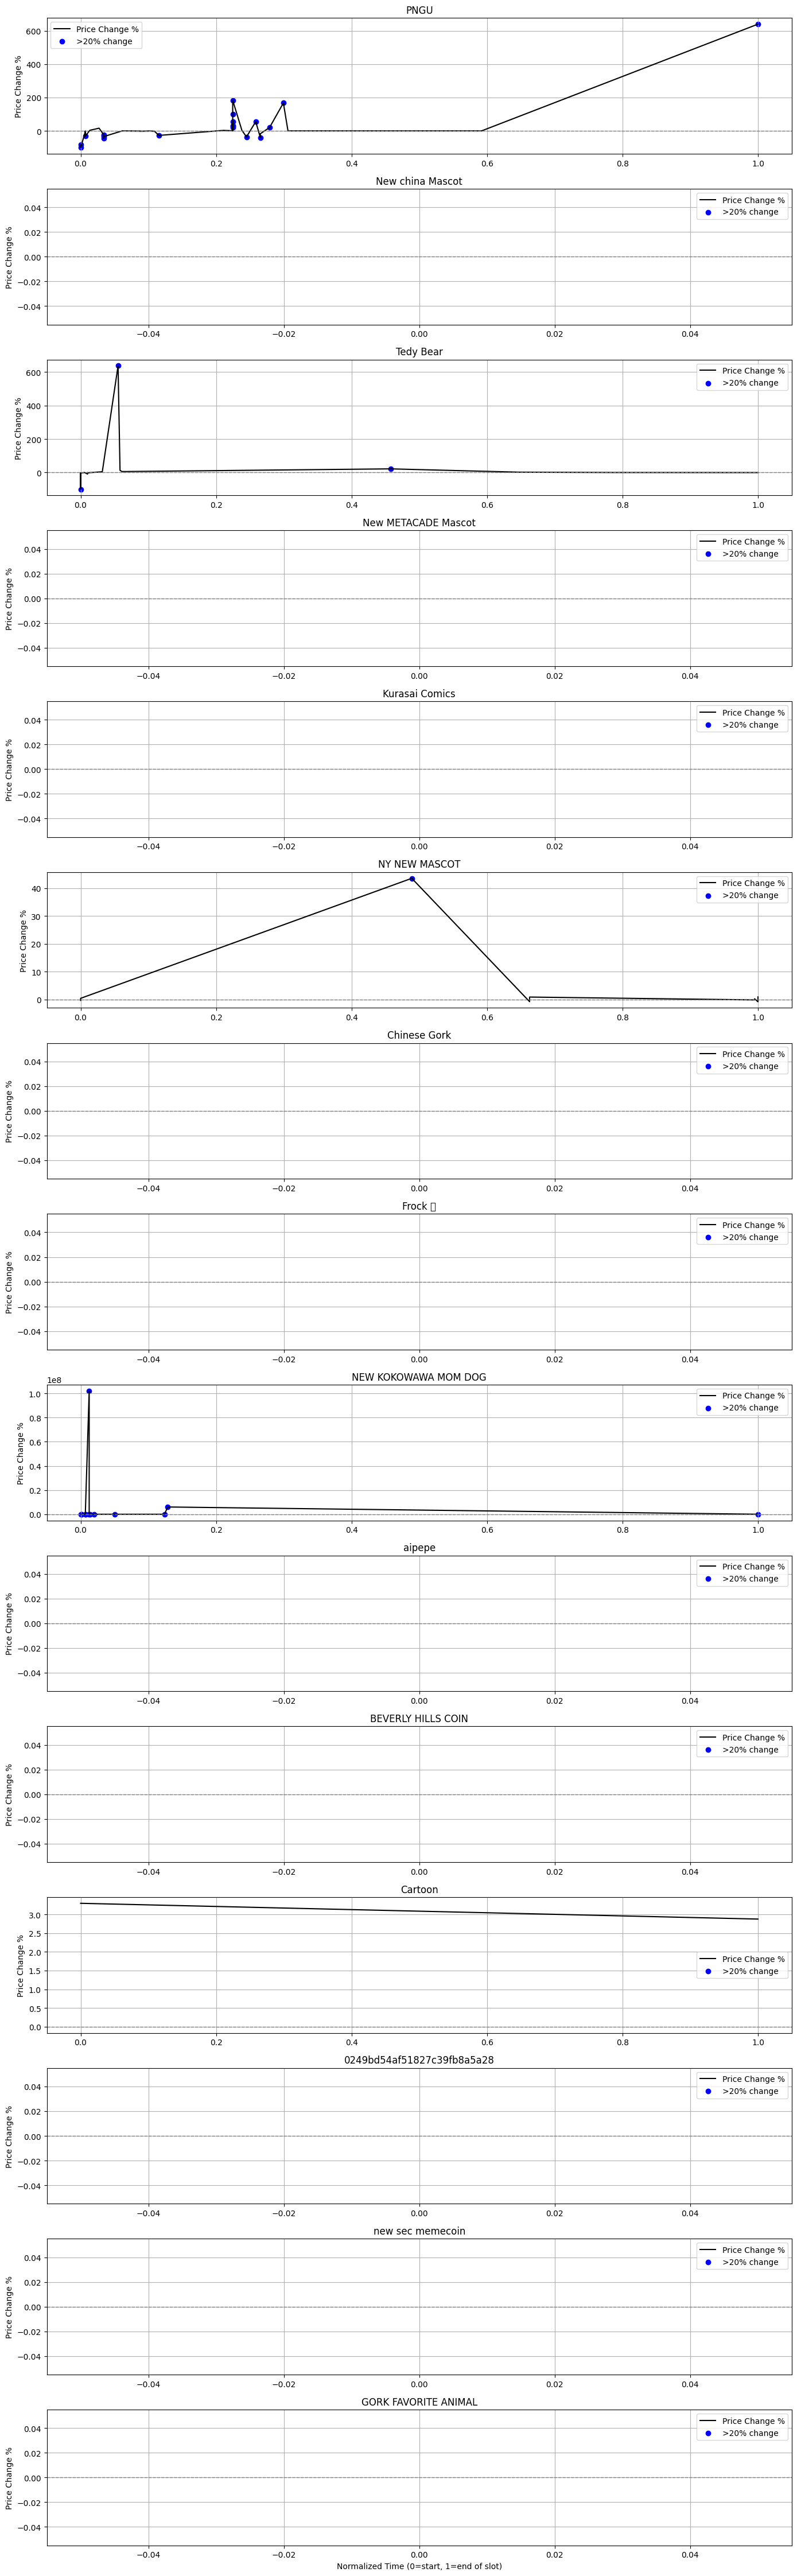

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


with open("db_original.json", "r") as f:
    data = json.load(f)


records = []
for token in data.get("tokens", []):
    try:
        name = token["info"]["name"]
        symbol = token["info"]["symbol"]
        address = token["address"]
        for tx in token.get("txs", []):
            if all(k in tx for k in ["user", "isBuy", "solAmount", "tokenAmount", "oldPrice", "newPrice", "priceChangePercent", "slot", "realSolReserves", "realTokenReserves"]):
                records.append({
                    "token_name": name,
                    "symbol": symbol,
                    "address": address,
                    "user": tx["user"],
                    "isBuy": tx["isBuy"],
                    "solAmount": tx["solAmount"],
                    "tokenAmount": tx["tokenAmount"],
                    "oldPrice": float(tx["oldPrice"]),
                    "newPrice": float(tx["newPrice"]),
                    "priceChangePercent": float(tx["priceChangePercent"]),
                    "slot": tx["slot"],
                    "realSolReserves": tx["realSolReserves"],
                    "realTokenReserves": tx["realTokenReserves"]
                })
    except Exception as e:
        print(f"Skipping a token due to parsing error: {e}")

df = pd.DataFrame(records)
df.sort_values(by=["token_name", "slot"], inplace=True)






























sample_tokens = random.sample(list(df["token_name"].unique()), min(15, len(df["token_name"].unique())))




























fig, axs = plt.subplots(len(sample_tokens), 1, figsize=(14, len(sample_tokens) * 3), sharex=False)

for i, token in enumerate(sample_tokens):
    token_df = df[df["token_name"] == token]
    if token_df.empty:
        continue

    slots = token_df["slot"].values
    x_normalized = (slots - slots.min()) / (slots.max() - slots.min())

    y_values = token_df["priceChangePercent"].values
    spikes_mask = np.abs(y_values) > 20

    axs[i].plot(x_normalized, y_values, label="Price Change %", color="black")
    axs[i].scatter(x_normalized[spikes_mask], y_values[spikes_mask], color='blue', label=">20% change")

    axs[i].axhline(0, color="gray", linestyle="--", linewidth=1)
    axs[i].set_title(token)
    axs[i].set_ylabel("Price Change %")
    axs[i].legend()
    axs[i].grid(True)

plt.xlabel("Normalized Time (0=start, 1=end of slot)")
plt.tight_layout()
plt.show()



Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing error: 'info'
Skipping a token due to parsing er

<ipython-input-5-2432069883c9>:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sorted = df.groupby(["token_name", "slot"], group_keys=False).apply(topological_sort_slot).reset_index(drop=True)


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,ETwZBUt3QehcMVoCboMFNouKa4F6JZRQvz3fQCxswksi,False,641206969,16495123937741,109181.874135,126295.458017,15.674382
1,CHacot2CfeLbcVtrnwLi9dJPQJEftGAc1XtB4R2yuZ6f,True,98019801,2560534676910,126295.458017,123395.996260,-2.295777



🧱 Slot: 337709691


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,BcD32GkcnSwXqvekMp8AYapLk8K9YTgLYTy8xfhbMtNT,False,217434635,5699378937375,123395.996260,129987.352663,5.341629
1,AgcDma8PA46hYbnJnAuyNNWxmECfpBn6T7rUheqqNAdo,False,76615121,2025169724632,129987.352663,132453.927172,1.897550



🧱 Slot: 337709692


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,CNNwHyr98bBEr7vSgytkKWXNq8JafsWHgbEvjdBfn8sm,False,568679456,15314802803926,132453.927172,153582.069375,15.951314
1,CNNwHyr98bBEr7vSgytkKWXNq8JafsWHgbEvjdBfn8sm,False,568679456,15314802803926,132453.927172,153582.069375,15.951314



🧱 Slot: 337709693


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,3fDM9fr9tmJoCSTZsQqLQ1kM1mVvMQAAEr4HCKKLYDvv,False,646072564,18027248076724,153582.069375,185760.011104,20.951627
1,CDXrT7jVWUeWUsbM6pFQ1qBiCVdpn4Bk3kMnfoENs1Ck,False,1426581,40571767205,185760.011104,185843.903421,0.045162



🧱 Slot: 337709694


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,9GSdfW252s9S1cdGrFZqeT55uvsgGK3hXJqVBZXcjm1g,False,52186773,1486553113255,185843.903421,188959.315794,1.67636



🧱 Slot: 337709696


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,3pCSoEQUozGbayGoNXYakxzASse1ZpJMxGHRFWiZRABz,False,320379495,9326078948758,200160.283383,223899.697944,11.860202



🧱 Slot: 337709697


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,HwzNXbZN8bC1UDWGFx1yWognFgn3ntm2obfX34LFXDST,True,14702970,431947196957,223899.697944,222701.848843,-0.534994
1,HcMGHQtkM3RzL8RQ4P231tEBW9iFWbVKDspVCmemmCVn,False,822314345,24762426462448,222701.848843,313622.366414,40.826117
2,78yV23nYcoeKqeLkNuwg7xNCXV2o1CvEGnH322Tt5UmK,False,243374697,7572503803356,313622.366414,354686.236347,13.093412



🧱 Slot: 337709705


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,AQtPtc3DYjjV6nrYj7cLcmdJZQcSyZBWGyr1wiZXi1V6,False,61983437,1947003477793,354686.236347,366765.734126,3.405686
1,AhS19NvaoPHBzHH7rzPPGWW6dThL6dtMB5VDek6kjPC2,False,584885349,18750756928731,366765.734126,533826.776108,45.549796



🧱 Slot: 337709707


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,CHacot2CfeLbcVtrnwLi9dJPQJEftGAc1XtB4R2yuZ6f,False,116255852,3810571257405,533826.776108,585286.926843,9.639859



🧱 Slot: 337709708


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,6W2FU8oZtbPJZRyD7S7zNFx4Jr4hneXyFMaotno38fjz,False,188768675,6248059006211,585286.926843,692255.63418,18.276285



🧱 Slot: 337709709


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,C377AnxQ4S41gkwZVqofGQgBQYqtYHeB8oggWffbmaUV,True,245049504,8096332132981,692255.63418,559253.72996,-19.212831



🧱 Slot: 337709710


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,HwzNXbZN8bC1UDWGFx1yWognFgn3ntm2obfX34LFXDST,False,558456717,18639060176657,559253.729960,9.847239e+05,76.078207
1,GEidvA34SYqdrJ32ZRkZTC6ntHXjfLDGCwfmFDwprHJt,False,163838542,5597294147488,984723.940778,1.256590e+06,27.608399



🧱 Slot: 337709711


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,GE3zAWkbrYwXbVDCjjjHjkTvUgM2s9uTqhPGLtqSbyUm,False,31823043,1094141492409,1.256590e+06,1.327155e+06,5.61553



🧱 Slot: 337709720


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,6U5GMqFUPG8GNBbYAeKi2aHqtAcZspZqZ1bQHPFKyJ8M,False,72045682,2485511260918,1.327155e+06,1.519451e+06,14.489363
1,DMrhLaup4iMFRpWZ2V4wHK1x6Mfw6vQXt2y58nbvVbsy,False,102753036,3565265345195,1.519451e+06,1.911429e+06,25.797358



🧱 Slot: 337709725


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,C377AnxQ4S41gkwZVqofGQgBQYqtYHeB8oggWffbmaUV,False,230790106,8096332132981,1.911429e+06,4.455031e+06,133.073300
1,JAbKpWPWCoJLycrfZXhoPgqzrdP2MYg28zVBq2UcSxxX,True,337319519,11792170530373,4.455031e+06,1.508032e+06,-66.149911



🧱 Slot: 337709728


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,2ftMSu88M3BinPYP8qs6AAEfdS4AQHNYkUm75hNbtAYq,False,73452691,2545534542968,1.508032e+06,1.765284e+06,17.058791



🧱 Slot: 337709758


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,46QhbMiiAHRPGCYfMMFcUhPdXNaMfymZabhqyERZ7BiC,False,44903174,1562198129993,1.765284e+06,1.969616e+06,11.575009



🧱 Slot: 337709790


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,6pu6LjqqPK9HdGHic12LaBHaV5YMGMYSr64vEZfPbi4W,False,44073,1535587389,1.969616e+06,1.969839e+06,0.01134



🧱 Slot: 337709805


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,4crAYQnZF2zQfWTCN1e9Di6pBBfpJEiD4vfyyDxfyHGZ,False,62171851,2170623324883,1.969839e+06,2.343725e+06,18.980527



🧱 Slot: 337709813


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,JAbKpWPWCoJLycrfZXhoPgqzrdP2MYg28zVBq2UcSxxX,False,333360839,11792170530373,2.343725e+06,1.098476e+12,4.686873e+07



🧱 Slot: 337709817


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,FNwFGfz3ZvRpmP1kGdNWXmPrZEV135VHwqhrckMd7Us2,True,1864031,66666000000,1.098476e+12,4.252753e+08,-99.961285



🧱 Slot: 337709819


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,JJaALTip7jEDKmXVnK4VK8QWzfPCM5xCkWDpMRETo8U,True,99912436,3561230934585,4.252753e+08,7.756867e+06,-98.176036



🧱 Slot: 337709848


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,5eBZxPKnf3Hb6bC9t9ozjF8jUzpn9HCyTNSg1dY7DfFL,True,19980000,709322965490,7.756867e+06,6.478162e+06,-16.484813



🧱 Slot: 337710613


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,Fmy4EtM1F22g9WsCeE5UC3XmNArGwDmXCpPz6KnmSbbA,False,683,24232699,6.478162e+06,6.478198e+06,0.000564



🧱 Slot: 337711450


,user,isBuy,solAmount,tokenAmount,oldPrice,newPrice,priceChangePercent
0,5eBZxPKnf3Hb6bC9t9ozjF8jUzpn9HCyTNSg1dY7DfFL,False,19979999,709322965490,6.478198e+06,7.756919e+06,19.738831


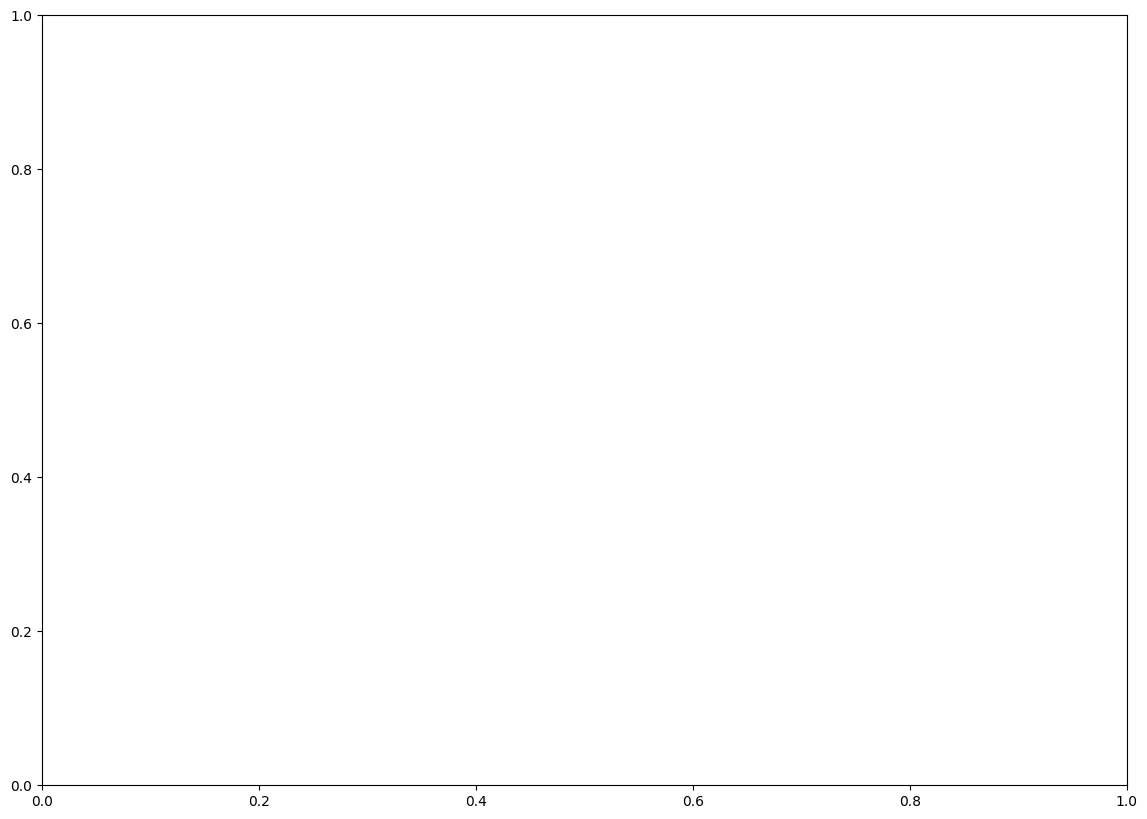

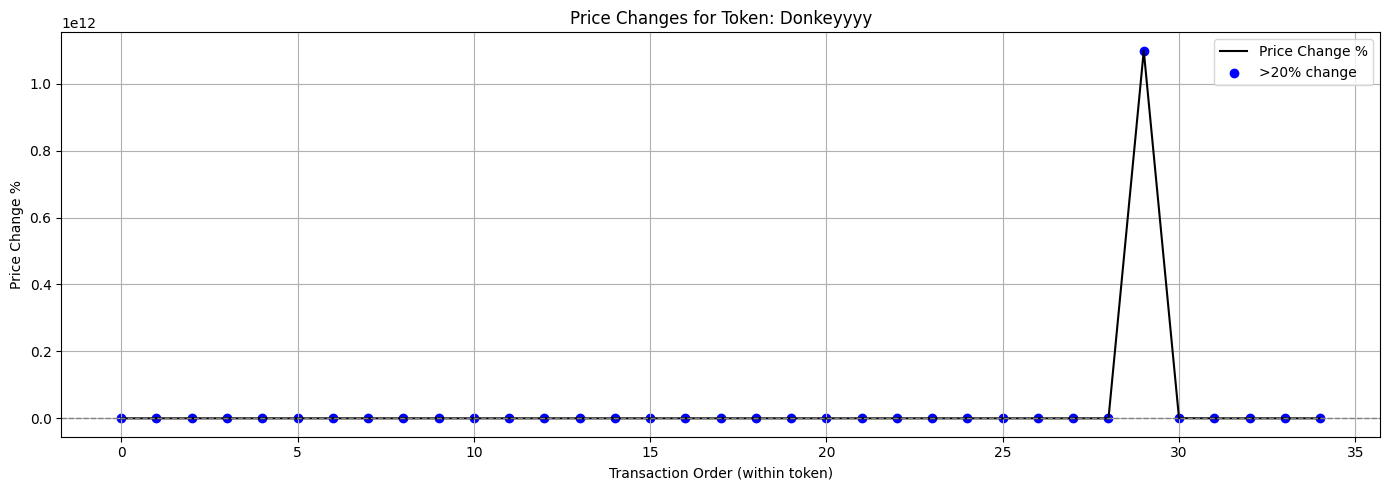

In [ ]:

import json
import pandas as pd
import numpy as np
import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt
import random


with open("db_original.json", "r") as f:
    data = json.load(f)


records = []
for token in data.get("tokens", []):
    try:
        name = token["info"]["name"]
        symbol = token["info"]["symbol"]
        address = token["address"]
        for tx in token.get("txs", []):
            if all(k in tx for k in ["user", "isBuy", "solAmount", "tokenAmount", "oldPrice", "newPrice", "priceChangePercent", "slot", "realSolReserves", "realTokenReserves"]):
                records.append({
                    "token_name": name,
                    "symbol": symbol,
                    "address": address,
                    "user": tx["user"],
                    "isBuy": tx["isBuy"],
                    "solAmount": tx["solAmount"],
                    "tokenAmount": tx["tokenAmount"],
                    "oldPrice": float(tx["oldPrice"]),
                    "newPrice": float(tx["newPrice"]),
                    "priceChangePercent": float(tx["priceChangePercent"]),
                    "slot": tx["slot"],
                    "realSolReserves": tx["realSolReserves"],
                    "realTokenReserves": tx["realTokenReserves"]
                })
    except Exception as e:
        print(f"Skipping a token due to parsing error: {e}")


df = pd.DataFrame(records)
df.sort_values(by=["token_name", "slot"], inplace=True)


def topological_sort_slot(group):
    if len(group) <= 1:
        return group

    group = group.copy().reset_index(drop=True)
    n = len(group)
    G = nx.DiGraph()


    for i in range(n):
        G.add_node(i)


    for i in range(n):
        for j in range(n):
            if i != j and group.loc[i, "newPrice"] <= group.loc[j, "oldPrice"]:
                G.add_edge(i, j)

    try:
        sorted_indices = list(nx.topological_sort(G))
        return group.loc[sorted_indices].reset_index(drop=True)
    except nx.NetworkXUnfeasible:

        return group


df_sorted = df.groupby(["token_name", "slot"], group_keys=False).apply(topological_sort_slot).reset_index(drop=True)
token_name = "Donkeyyyy"
token_df = df_sorted[df_sorted["token_name"] == token_name].copy()
fig, axs = plt.subplots(1, 1, figsize=(14, 10), sharex=False)

for slot, group in token_df.groupby("slot"):
    print(f"\n🧱 Slot: {slot}")
    display(group[[
        "user", "isBuy", "solAmount", "tokenAmount",
        "oldPrice", "newPrice", "priceChangePercent"
    ]].reset_index(drop=True))


x_indices = np.arange(len(token_df))
y_values = token_df["newPrice"].values
spikes_mask = np.abs(y_values) > 20


plt.figure(figsize=(14, 5))
plt.plot(x_indices, y_values, label="New price", color="black")
plt.scatter(x_indices[spikes_mask], y_values[spikes_mask], color='blue', label=">20% change")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)


token_name = token_df["token_name"].iloc[0] if not token_df.empty else "Unknown Token"
plt.title(f"Price Changes for Token: {token_name}")
plt.xlabel("Transaction Order (within token)")
plt.ylabel("Price Change %")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

























# plt.show()

In [ ]:
import json
import pandas as pd


with open("db.json", "r") as file:
    db = json.load(file)


records = []
for token in db["tokens"]:
    try:
      token_address = token["address"]
      token_name = token["info"]["name"]
      token_symbol = token["info"]["symbol"]
      for tx in token["txs"]:
          tx_record = {
              "token_address": token_address,
              "token_name": token_name,
              "token_symbol": token_symbol,
              **tx
          }
          records.append(tx_record)
    except:
      print("Failed to parse the token")


df = pd.DataFrame(records)

Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token
Failed to parse the token


In [ ]:
df_sorted = df.sort_values(by=["token_address", "slot"])


token_heuristics = {}


for token_address, group in df_sorted.groupby("token_address"):
    group = group.reset_index(drop=True)


    h1_bot_activity = False
    h2_rapid_sells = False
    h3_single_wallet_dump = False
    h4_price_crash = False


    h1_bot_activity = False
    TOLERANCE = 1e-5  # Allowing for minor rounding differences

    for slot, slot_df in group.groupby("slot"):
        for user, user_df in slot_df.groupby("user"):
            buys = user_df[user_df["isBuy"] == True]
            sells = user_df[user_df["isBuy"] == False]

            for _, buy in buys.iterrows():
                for _, sell in sells.iterrows():
                    if abs(buy["solAmount"] - sell["solAmount"]) <= TOLERANCE:
                        h1_bot_activity = True
                        break
                if h1_bot_activity:
                    break
            if h1_bot_activity:
                break
        if h1_bot_activity:
            break


    sell_slots = group[group["isBuy"] == False]["slot"].tolist()
    for i in range(len(sell_slots)):
        window = [s for s in sell_slots if sell_slots[i] <= s <= sell_slots[i] + 5]
        if len(window) >= 3:
            h2_rapid_sells = True
            break


    sell_data = group[group["isBuy"] == False]
    sell_volume_by_user = sell_data.groupby("user")["solAmount"].sum()
    total_sell_volume = sell_volume_by_user.sum()
    if not sell_volume_by_user.empty and (sell_volume_by_user.max() / total_sell_volume) > 0.7:
        h3_single_wallet_dump = True


    prices = group["newPrice"].astype(float)
    if len(prices) > 0:
        max_price = prices.max()
        min_price = prices.min()
        if max_price > 0 and ((max_price - min_price) / max_price) > 0.6:
            h4_price_crash = True


    heuristics_true = sum([h1_bot_activity, h2_rapid_sells, h3_single_wallet_dump, h4_price_crash])
    is_rug_pull = 1 if heuristics_true >= 2 else 0

    token_heuristics[token_address] = {
        "token_name": group["token_name"].iloc[0],
        "token_symbol": group["token_symbol"].iloc[0],
        "h1_bot_activity": h1_bot_activity,
        "h2_rapid_sells": h2_rapid_sells,
        "h3_single_wallet_dump": h3_single_wallet_dump,
        "h4_price_crash": h4_price_crash,
        "rug_pull_label": is_rug_pull
    }


label_df = pd.DataFrame.from_dict(token_heuristics, orient='index').reset_index().rename(columns={"index": "token_address"})
df_labeled = df.merge(label_df[["token_address", "rug_pull_label"]], on="token_address", how="left")

,token_name,token_symbol,token_address
10,bromance,BROMANCE,1a4aj9EzfsYUwQNyAVMdqNT1Dc14hVQfTuVqXH2nbgj
73,Binance Lightsaber,LIGHTSABER,2HW5zexUZAYaMuY4VDc89eYwmUoPbxf9GxM12MNMpump
119,good values,values,2Tp8A9SE56pPaFUXtDHmR5oiHqvH6SCm7NEhoGfYN331
255,May the 4th be with you,May4th,31iCXy6fs1R6EgmBkF6zvSSPSdyBy4SpZmpfo4PKpump
275,Ing Stablecoin,IUSD,369oULU1bdN8pXSqaaHE4M6jPFFzANnntR4sYajcNdMz
...,...,...,...
3685,yoda pepe,#yepa,HmsLyNz4iotYVAMmDQuK5L5rzV9s9M45rM3F4LAapump
4027,Elon Ma,ELOMA,zZi5PC6VP64j9bFGzgUxaaCKZCmtYL41Nw4CQvspump
4039,"1 Death Star = $852,000,000,000",1DeathStar,zxf4bgYWvDxmmKxQpXHhgv7TSvwqTcAPsjcEdCxpump
4040,gork favorite person starwars,sith lord,zxu2MhSsAgSrnBJgtYzp7NatVVLwYsHuYGyUpYtpump


In [ ]:
import numpy as np


features = []


df_labeled = df_labeled.sort_values(by=["token_address", "slot"])


for token_address, group in df_labeled.groupby("token_address"):
    group = group.reset_index(drop=True)


    total_txns = len(group)
    total_buys = group["isBuy"].sum()
    total_sells = total_txns - total_buys
    sell_to_buy_ratio = total_sells / total_buys if total_buys != 0 else np.nan
    unique_traders = group["user"].nunique()


    slot_diffs = group["slot"].diff().fillna(0)
    avg_slot_interval = slot_diffs.mean()


    price_changes = group["priceChangePercent"].astype(float)
    avg_price_change = price_changes.mean()
    max_price_drop = price_changes.min()  # most negative drop
    reserves_delta = group["realSolReserves"].iloc[-1] - group["realSolReserves"].iloc[0]


    holder_balances = group.groupby("user")["tokenAmount"].sum()
    total_token_distributed = holder_balances.sum()


    if total_token_distributed > 0:
        top_10_share = holder_balances.sort_values(ascending=False).head(10).sum() / total_token_distributed
    else:
        top_10_share = np.nan

    label = group["rug_pull_label"].iloc[0]

    features.append({
        "token_address": token_address,
        "total_txns": total_txns,
        "total_buys": total_buys,
        "total_sells": total_sells,
        "sell_to_buy_ratio": sell_to_buy_ratio,
        "unique_traders": unique_traders,
        "avg_slot_interval": avg_slot_interval,
        "avg_price_change": avg_price_change,
        "max_price_drop": max_price_drop,
        "reserves_delta": reserves_delta,
        "top_10_holder_share": top_10_share,
        "rug_pull_label": label
    })


features_df = pd.DataFrame(features)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86       521
           1       0.59      0.98      0.74       186

    accuracy                           0.82       707
   macro avg       0.79      0.87      0.80       707
weighted avg       0.88      0.82      0.83       707

Confusion Matrix:
 [[395 126]
 [  4 182]]
ROC AUC Score: 0.9585887354756156


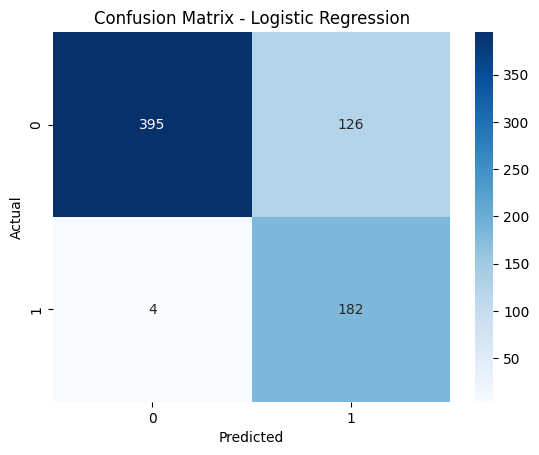

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt


features_clean = features_df.dropna()


X = features_clean.drop(columns=["token_address", "rug_pull_label"])
y = features_clean["rug_pull_label"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
print("Total tokens with valid features:", len(features_clean))


Total tokens with valid features: 3531


In [ ]:
print("Original tokens:", len(features_df))
print("After dropping NaNs:", len(features_clean))

Original tokens: 4043
After dropping NaNs: 3531


<ipython-input-11-8a165546ea02>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=importance_df, palette="coolwarm")


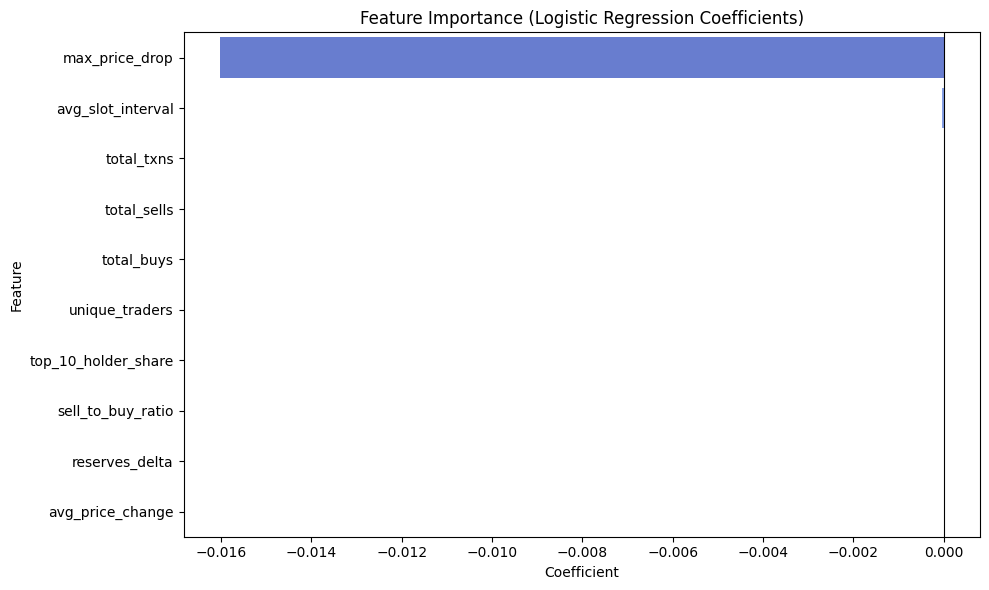

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


feature_names = X.columns.tolist()


coefficients = model.coef_[0]


importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=importance_df, palette="coolwarm")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:26:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       521
           1       0.88      0.91      0.89       186

    accuracy                           0.94       707
   macro avg       0.92      0.93      0.93       707
weighted avg       0.94      0.94      0.94       707

Confusion Matrix:
 [[497  24]
 [ 17 169]]
ROC AUC Score: 0.9857284378676243


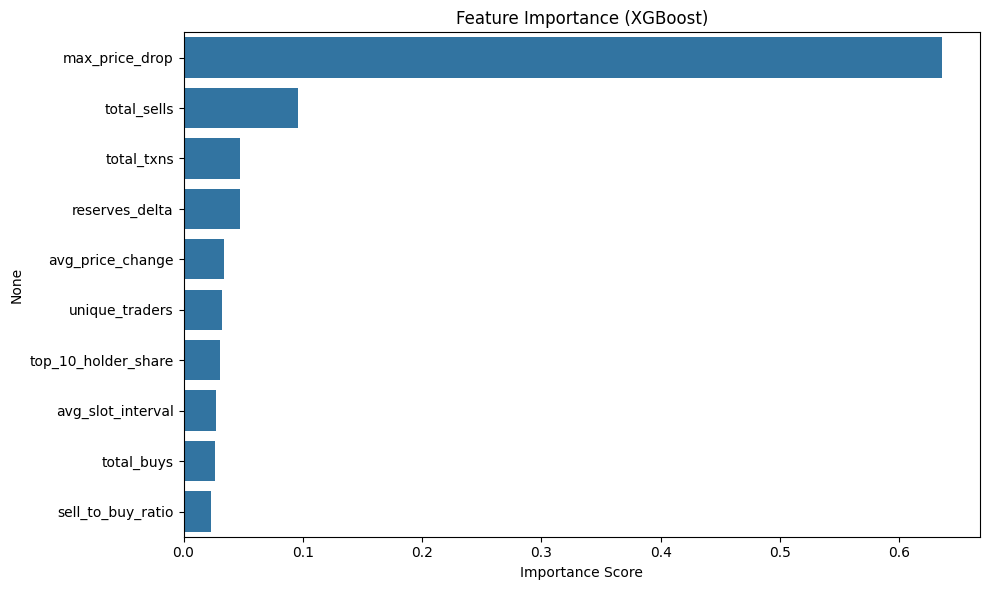

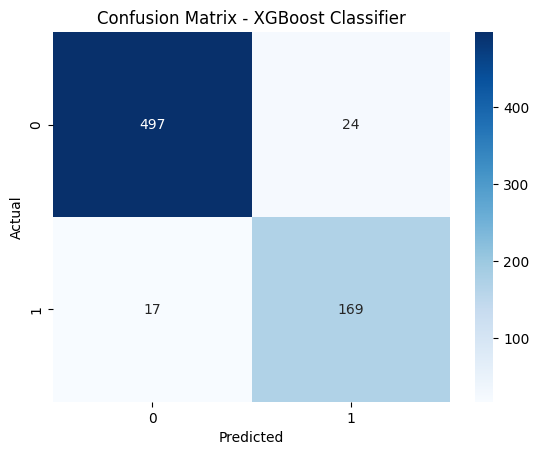

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)


xgb_pred = xgb_model.predict(X_test)
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]


print("Classification Report:\n", classification_report(y_test, xgb_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))
print("ROC AUC Score:", roc_auc_score(y_test, xgb_prob))


importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - XGBoost Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

MAX_SLOT_WINDOW = 9000  # ~50–60 minutes
SEQUENCE_LENGTH = 100   # final time steps to pad/truncate to


FEATURE_COLUMNS = ["solAmount", "tokenAmount", "priceChangePercent", "realSolReserves", "realTokenReserves", "isBuy"]

lstm_df = df_labeled[["token_address", "slot"] + FEATURE_COLUMNS + ["rug_pull_label"]].dropna()


scaler = StandardScaler()
lstm_df[FEATURE_COLUMNS] = scaler.fit_transform(lstm_df[FEATURE_COLUMNS])


token_sequences = []
labels = []

for token_address, group in lstm_df.groupby("token_address"):
    group = group.sort_values("slot")
    creation_slot = group["slot"].min()
    group = group[group["slot"] - creation_slot <= MAX_SLOT_WINDOW]


    features = group[FEATURE_COLUMNS].values


    if len(features) < SEQUENCE_LENGTH:
        pad = np.zeros((SEQUENCE_LENGTH - len(features), len(FEATURE_COLUMNS)))
        features = np.vstack([features, pad])
    else:
        features = features[:SEQUENCE_LENGTH]

    token_sequences.append(features)
    labels.append(group["rug_pull_label"].iloc[0])



X_lstm = np.array(token_sequences)
y_lstm = np.array(labels)

print("X shape:", X_lstm.shape)  # (num_tokens, sequence_length, num_features)
print("y shape:", y_lstm.shape)


X shape: (4043, 100, 6)
y shape: (4043,)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.7916 - loss: 0.5795 - val_accuracy: 0.8765 - val_loss: 0.3587
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8841 - loss: 0.3297 - val_accuracy: 0.8735 - val_loss: 0.3198
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8775 - loss: 0.3005 - val_accuracy: 0.8765 - val_loss: 0.3078
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8844 - loss: 0.2683 - val_accuracy: 0.8457 - val_loss: 0.3246
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.8821 - loss: 0.2770 - val_accuracy: 0.8611 - val_loss: 0.3157
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9059 - loss: 0.2406 - val_accuracy: 0.8765 - val_loss: 0.2878
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.8968 - loss: 0.2458 - val_accuracy: 0.8765 - val_loss: 0.2854
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9063 - loss: 0.2422 - val_accuracy: 0.8827 - val_loss:

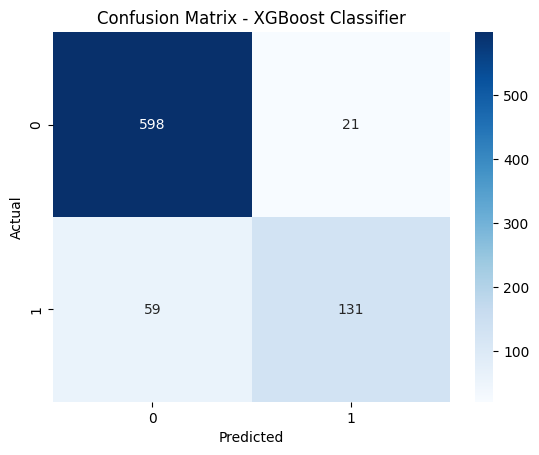

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt


X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm, y_lstm, test_size=0.2, stratify=y_lstm, random_state=42
)


model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32,
                    validation_split=0.1, verbose=1)


y_pred_prob = model.predict(X_test_lstm).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test_lstm, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test_lstm, y_pred))

print("ROC AUC Score:")
print(roc_auc_score(y_test_lstm, y_pred_prob))


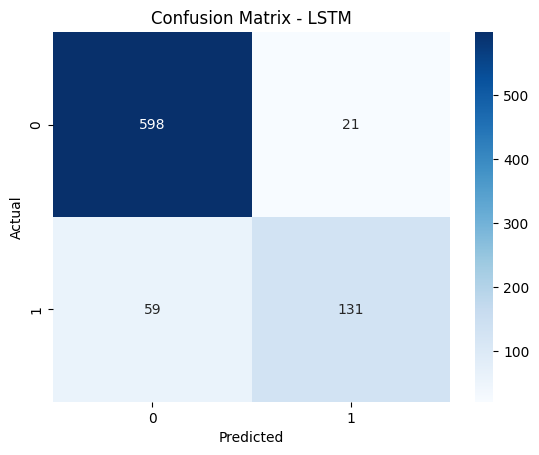

In [ ]:

sns.heatmap(confusion_matrix(y_test_lstm, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


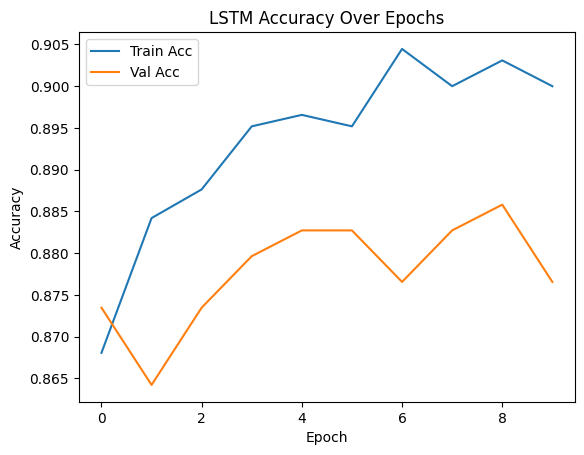

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('LSTM Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()